In [9]:
import awkward as ak
import os
from coffea.nanoevents import NanoEventsFactory, PFNanoAODSchema
import warnings
import matplotlib.pyplot as plt
import numpy as np
import hist
import json
import xgboost as xgb
import pickle

In [2]:
qcd = {}
path = '/project01/ndcms/cmoore24/skims/gluon_finding/mc'
for i in os.listdir(path):
    if 'qcd' in i:
        qcd_sample = ak.from_parquet(f'{path}/{i}/*')
        qcd_sample['GenJetAK8'] = qcd_sample.GenJetAK8[qcd_sample.goodjets.genJetAK8Idx]
        qcd_sample['goodjets', 'isGluon'] = (qcd_sample.GenJetAK8.partonFlavour == 21)

        # qcd_sample["goodjets"] = qcd_sample.goodjets[qcd_sample.goodjets.btag_count == 0]
        # mask = ~ak.is_none(ak.firsts(qcd_sample.goodjets))
        # qcd_sample = qcd_sample[mask]
              
        qcd[i] = qcd_sample

In [5]:
train = 'kinematics'
trees = '5000'

In [10]:
path = f'/scratch365/cmoore24/training/hgg/quark_gluon/output/{train}/{trees}'
bst = xgb.Booster()
bst.load_model(f'{path}/bdt_model.json')
scaler = f'{path}/scaler.pkl'
with open(scaler, 'rb') as f:
    scaler = pickle.load(f)

In [11]:
feature_names = [
    'area',
    'eta',
    'mass',
    'msoftdrop',
    'n2b1',
    'n3b1',
    'phi',
    'pt',
    'tau1',
    'tau2',
    'tau3',
    'tau4',
]

In [13]:
for i in qcd:
    print(f'Doing {i}')
    qcd_np = np.column_stack([ak.to_numpy(qcd[i].goodjets[feature][:,0]) for feature in feature_names])
    qcd_np = scaler.transform(qcd_np)
    qcd_xgb = xgb.DMatrix(qcd_np, feature_names=feature_names)
    qcd[i]['goodjets', 'GluonBDT'] = bst.predict(qcd_xgb)

Doing qcd_1000to1400
Doing qcd_1400to1800
Doing qcd_1800to2400
Doing qcd_2400to3200
Doing qcd_3200toInf
Doing qcd_470to600
Doing qcd_600to800
Doing qcd_800to1000


In [16]:
path = '/scratch365/cmoore24/training/hgg/batch2024/ml_results_checking'
with open(f'{path}/subregion_event_totals.json', 'r') as f:
    totals = json.load(f)

In [17]:
with open(f'{path}/my_xsecs.json', 'r') as f:
    xsecs = json.load(f)

In [18]:
xsecs2 = {}
for i in xsecs:
    if type(xsecs[i]) == dict:
        for j in xsecs[i]:
            xsecs2[j] = xsecs[i][j]
    else:
        xsecs2[i] = xsecs[i]
xsecs = xsecs2

In [19]:
totals2 = {}
for i in totals:
    if type(totals[i]) == dict:
        for j in totals[i]:
            totals2[f'{i}_{j}'] = totals[i][j]
    else:
        totals2[i] = totals[i]
totals = totals2

In [25]:
def make_scaled_hist(group, prefix, var_name, range_down, range_up, bins=40, which_index=None, absv=False):
    hists = {}
    for i in group:
        new_hist = hist.Hist.new.Reg(bins, range_down, range_up, 
                                     name='variable', label=var_name).Weight()
        if which_index==None:
            to_fill = group[i][prefix][var_name]
        else:
            to_fill = group[i][prefix][var_name][:,which_index]
        if absv:
            to_fill = abs(to_fill)
        new_hist.fill(variable=to_fill)
        hists[i] = new_hist
        
    for i in hists:
        scale = ((44.99*(xsecs[i]*1000))/totals[i])
        hists[i].view(flow=True)[:] *= scale

    sum_hist = sum([hists[i] for i in hists])

    return sum_hist

In [26]:
bdt_score = make_scaled_hist(qcd, 'goodjets', 'GluonBDT',
                             0, 1, 40, 0, absv=False)

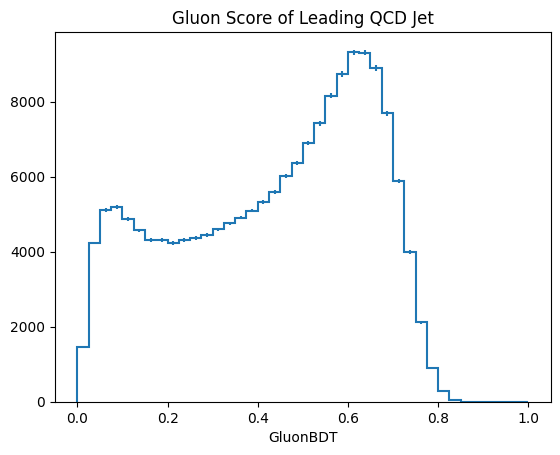

In [27]:
bdt_score.plot1d()
plt.title('Gluon Score of Leading QCD Jet')
plt.show()

In [81]:
per = {}
counts = {}
for j in range(0, 100, 5):
    qcd_cut = {}
    for i in qcd:
        sample_goodjets = qcd[i].goodjets[(qcd[i].goodjets.GluonBDT >= j/100) & (qcd[i].goodjets.pt <= 1000)]
    
        mask = ~ak.is_none(ak.firsts(sample_goodjets))
        qcd_sample = qcd[i][mask]
    
        qcd_cut[i] = qcd_sample

    qcd_leadcounts = make_scaled_hist(qcd_cut, 'GenJetAK8', 'partonFlavour', 0, 22, 22, 0, absv=True)
    per[str(j)] = sum(qcd_leadcounts[20:].values()) / (sum(qcd_leadcounts[:].values()))
    counts[str(j)] = sum(qcd_leadcounts[:].values())

/tmp/ipykernel_2116151/961770521.py:14: RuntimeWarning: invalid value encountered in scalar divide
  per[str(j)] = sum(qcd_leadcounts[20:].values()) / (sum(qcd_leadcounts[:].values()))


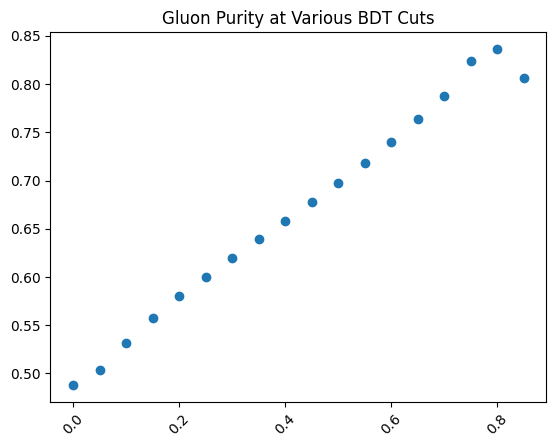

In [82]:
plt.scatter(x=[int(i)/100 for i in list(per.keys())], y=list(per.values()), label='hard')
plt.title('Gluon Purity at Various BDT Cuts')
plt.xticks(rotation=45)
plt.show()

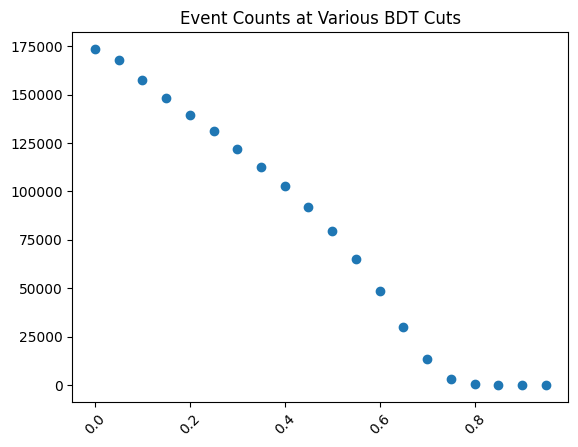

In [83]:
plt.scatter(x=[int(i)/100 for i in list(per.keys())], y=list(counts.values()), label='hard')
plt.title('Event Counts at Various BDT Cuts')
plt.xticks(rotation=45)
plt.show()

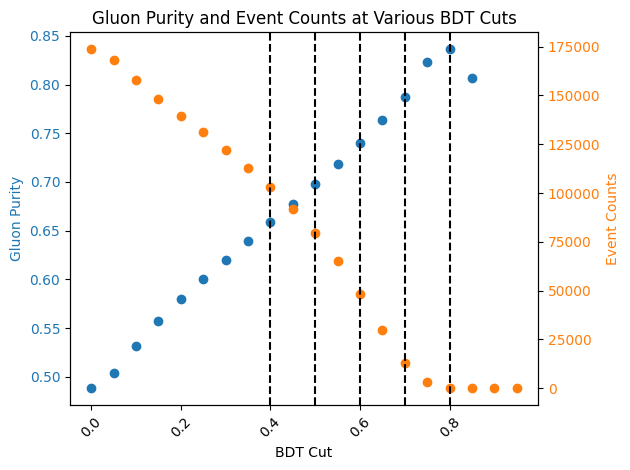

In [84]:
fig, ax1 = plt.subplots()

x_vals = [int(i)/100 for i in list(per.keys())]
y1 = list(per.values())
y2 = list(counts.values())

ax1.scatter(x_vals, y1, color='tab:blue', label='Purity')
ax1.set_ylabel('Gluon Purity', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xlabel('BDT Cut')
ax1.set_title('Gluon Purity and Event Counts at Various BDT Cuts')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.scatter(x_vals, y2, color='tab:orange', label='Event Count')
ax2.set_ylabel('Event Counts', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.axvline(x=0.4, linestyle='--', color='black')
plt.axvline(x=0.5, linestyle='--', color='black')
plt.axvline(x=0.6, linestyle='--', color='black')
plt.axvline(x=0.7, linestyle='--', color='black')
plt.axvline(x=0.8, linestyle='--', color='black')

plt.tight_layout()
plt.show()

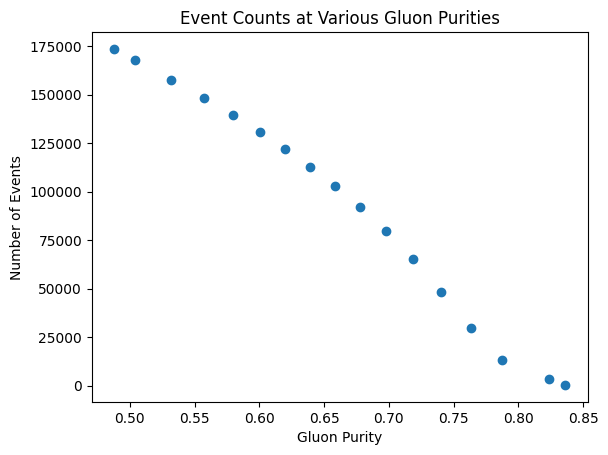

In [85]:
plt.scatter(x=list(per.values())[:17], y=list(counts.values())[:17], label='hard')
plt.title('Event Counts at Various Gluon Purities')
plt.xticks(rotation=0)
plt.xlabel('Gluon Purity')
plt.ylabel('Number of Events')
plt.show()

In [86]:
list(counts.values())[:17], list(per.values())[:17]

([173613.98110013263,
  167933.248676955,
  157630.8515333385,
  148187.43692144944,
  139560.73765193095,
  131022.4434632597,
  122211.87584918074,
  112872.54605786182,
  102873.25638026898,
  91972.19357150658,
  79599.46352491419,
  65288.63882749621,
  48403.08205697527,
  29795.184559730293,
  13218.396491489755,
  3354.8292744908913,
  338.5699913284807],
 [0.48803747434810746,
  0.5035829779746702,
  0.5317952005373041,
  0.5573682430498619,
  0.5799344233125278,
  0.6005117793297073,
  0.6200416622688143,
  0.6392636634008122,
  0.6585329648841132,
  0.6778672843063828,
  0.6976286331177753,
  0.7183796365927111,
  0.740378929564401,
  0.7636728076886456,
  0.7873873955634673,
  0.8236567541991754,
  0.8363343296331743])